# RNN MNIST Classifier

## Erkennung von Handgeschriebenen Ziffern (MNIST-Datensatz) mit verschiedenen RNNs

Als erstes wird hier alles nötige importiert (wir verwenden hier Tensorflow ohne kein Keras) und ein paar Einstellungen werden vorgenommen:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import tensorflow as tf

## Klassifikation mit einem einfachen RNN

Zunächst versuchen wir die Ziffern mit einem einfachen RNN zu klassifizieren. Wir verwenden 28 Input-Neuronen, die nacheinander je 28 Inputs erhallten (die MNIST-Bilder haben die größe 28x28). Als Hidden-Layer verwenden wir 150 BasicRNNCells (also einfache rekurrente Neuronen von Tensorflow). Der Output ist wie üblich eine vollvermaschte Schicht von 10 Neuronen, die mit einer Softmax-Funktion entscheiden um welche Ziffer es sich bei der Eingabe wahrscheinlich handelt.

Das Netz besteht also aus:
- 28 Eingabeneuronen (jede erhällt nacheinander 28 Inputs)
- 150 einfache RNN Zellen (BasicRnnCell von Tensorflow) als Hidden-Layer
- 10 Outputneuronen mit einer Softmax-Funktion zur Klassifizierung

In [2]:
#Das modell wird resettet um zu verhindern, das wir vorher schon etwas ausgeführt haben, das zu Problemen führen könnte
reset_graph()

#Die Eingabe- und Außgabegrößen und die Anzahl der Neuronen im Hidden-Layer werden festgelegt
n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

#Die Placeholder sind in Tensorflow dazu da, die Eingaben (X Matrix) und die Ausgaben (y Vektor) im Graphen zu modellieren
#Die Placeholder werden im Training und in der Ausführung durch die Werte des Datensatzes ersetzt
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

#Das Modell wird mit Tensorflow erstellt (sieht nicht ganz so schön aus wie mit Keras, tut aber im Prinzip das selbe...)
#Das Hidden-Layer wird erstellt und erhällt als Eingaben die MNIST Daten (X Matrix)
basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

#Die Ausgabeschicht ist eine Vollvermaschte Schicht mit 10 Ausgabeneuronen und einer Softmax-Aktivierungsfunktion
logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)

#Das Modell wird mit einem Adams Optimierer trainiert, der die loss Funktion minimiert
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
#Hier werden die Ausgaben des Netzes mit den korrekten werten (aus dem Placeholder-Vektor y) verglichen
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

#Erzeugt einige Warnungen, weil einiges schon wieder Veraltet ist (das geht in Tensorflow sehr schnell)
#Funktioniert aber trotzdem noch

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


### Daten laden, aufteilen und trainieren

Die Daten des MNIST-Datensatzes werden geladen, in Trainings-, Test- und Validierungssets unterteilt und dann wird das Netz (10 Epochen lang) trainiert.

In [3]:
#Die Daten werden geladen und aufgeteilt (und als Eingaben für das Netz vorbereitet)
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

X_test = X_test.reshape((-1, n_steps, n_inputs))


#Das Netz wird über 10 Epochen mit einer Batchsize von 150 trainiert
n_epochs = 10
batch_size = 150

train_accuracy_simple_rnn = np.empty(n_epochs)
test_accuracy_simple_rnn = np.empty(n_epochs)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        train_accuracy_simple_rnn[epoch] = acc_batch
        test_accuracy_simple_rnn[epoch] = acc_test
        print(epoch + 1, "Last batch accuracy:", acc_batch, "Test accuracy:", acc_test)

1 Last batch accuracy: 0.9533333 Test accuracy: 0.9288
2 Last batch accuracy: 0.96 Test accuracy: 0.9471
3 Last batch accuracy: 0.96 Test accuracy: 0.9498
4 Last batch accuracy: 0.97333336 Test accuracy: 0.9644
5 Last batch accuracy: 0.97333336 Test accuracy: 0.9687
6 Last batch accuracy: 0.93333334 Test accuracy: 0.9684
7 Last batch accuracy: 0.98 Test accuracy: 0.9662
8 Last batch accuracy: 1.0 Test accuracy: 0.9695
9 Last batch accuracy: 0.99333334 Test accuracy: 0.968
10 Last batch accuracy: 0.99333334 Test accuracy: 0.9721


# Klassifikation mit einem tiefen RNN-Netz (3 Hidden-Layer)

Hier trainieren wir ein tiefes Netz mit 3 Hidden-Layern auf die selben MNIST-Daten um die Netze zu vergleichen

Das Netz besteht diesmal aus:
- 28 Eingabeneuronen (jede erhällt nacheinander 28 Inputs)
- 3 Hidden-Layern mit je 100 einfachen RNN Zellen (BasicRnnCell von Tensorflow)
- 10 Outputneuronen mit einer Softmax-Funktion zur Klassifizierung

In [4]:
#Der vorher erstellte Graph wird wieder gelöscht
reset_graph()

#Die Eingabe- und Außgabegrößen werden festgelegt
n_steps = 28
n_inputs = 28
n_outputs = 10

learning_rate = 0.001

#Die Placeholder sind in Tensorflow dazu da, die Eingaben (X Matrix) und die Ausgaben (y Vektor) im Graphen zu modellieren
#Die Placeholder werden im Training und in der Ausführung durch die Werte des Datensatzes ersetzt
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

#Die Anzahl der Neuronen pro Hidden-Layer und die Anzahl der Hidden-Layer wird festgelegt
n_neurons = 100
n_layers = 3

#Die Hidden-Layers werden als MultiRNNCell aus einer Liste von einfachen RNN-Layern erstellt
layers = [tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu) for layer in range(n_layers)]
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

#Die Ausgabeschicht ist eine Vollvermaschte Schicht mit 10 Ausgabeneuronen und einer Softmax-Aktivierungsfunktion
states_concat = tf.concat(axis=1, values=states)
logits = tf.layers.dense(states_concat, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)

#Es wird wieder ein Adams-Optimierer erstellt, der die loss-funktion minimiert
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
#Hier werden die Ausgaben des Netzes mit den korrekten werten (aus dem Placeholder-Vektor y) verglichen
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

### Das Netz wird wieder in 10 Epochen trainiert

In [5]:
#Die Daten sind schon geladen und aufgeteilt (für die Vergleichbarkeit werden die selben Daten verwendet)

#Das Netz wird wieder über 10 Epochen trainiert
n_epochs = 10
batch_size = 150

train_accuracy_deep_rnn = np.empty(n_epochs)
test_accuracy_deep_rnn = np.empty(n_epochs)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        train_accuracy_deep_rnn[epoch] = acc_batch
        test_accuracy_deep_rnn[epoch] = acc_test
        print(epoch + 1, "Last batch accuracy:", acc_batch, "Test accuracy:", acc_test)

1 Last batch accuracy: 0.94 Test accuracy: 0.94
2 Last batch accuracy: 0.93333334 Test accuracy: 0.9563
3 Last batch accuracy: 0.96666664 Test accuracy: 0.9691
4 Last batch accuracy: 0.99333334 Test accuracy: 0.9714
5 Last batch accuracy: 0.98 Test accuracy: 0.9672
6 Last batch accuracy: 0.96666664 Test accuracy: 0.9779
7 Last batch accuracy: 0.9866667 Test accuracy: 0.9782
8 Last batch accuracy: 0.96666664 Test accuracy: 0.9767
9 Last batch accuracy: 0.99333334 Test accuracy: 0.9777
10 Last batch accuracy: 0.98 Test accuracy: 0.9738


# Klassifikation mit LSTM Zellen

Hier trainieren wir wieder die MNIST-Daten auf einem tiefen RNN (3 Hidden-Layer). Aber statt der einfachen RNN Zellen verwenden wir dieses mal LSTM Zellen.

Das Netz besteht diesmal aus:
- 28 Eingabeneuronen (jede erhällt nacheinander 28 Inputs)
- 3 Hidden-Layern mit je 100 LSTM Zellen (BasicLSTMCell von Tensorflow)
- 10 Outputneuronen mit einer Softmax-Funktion zur Klassifizierung

In [6]:
#Der vorherige Graph wird mal wieder gelösch
reset_graph()

#Die Eingabe- und Außgabegrößen und die Anzahl der Neuronen im Hidden-Layer werden festgelegt
n_steps = 28
n_inputs = 28
n_neurons = 100
n_outputs = 10
n_layers = 3

learning_rate = 0.001

#Die Placeholder sind in Tensorflow dazu da, die Eingaben (X Matrix) und die Ausgaben (y Vektor) im Graphen zu modellieren
#Die Placeholder werden im Training und in der Ausführung durch die Werte des Datensatzes ersetzt
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

#Die Hidden-Layers werden wieder als eine MultiRNNCell modelliert; diesmal sind die einzelnen Neuronen aber LSTM Zellen
lstm_cells = [tf.nn.rnn_cell.BasicLSTMCell(num_units=n_neurons) for layer in range(n_layers)]
multi_cell = tf.nn.rnn_cell.MultiRNNCell(lstm_cells)
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
top_layer_h_state = states[-1][1]

#Die Ausgabeschicht ist eine Vollvermaschte Schicht mit 10 Ausgabeneuronen und einer Softmax-Aktivierungsfunktion
logits = tf.layers.dense(top_layer_h_state, n_outputs, name="softmax")
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)

#Es wird wieder ein Adams-Optimierer erstellt, der die loss-funktion minimiert
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
#Hier werden die Ausgaben des Netzes mit den korrekten werten (aus dem Placeholder-Vektor y) verglichen
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').


### Das Netz wird wieder in 10 Epochen trainiert

In [7]:
#Die Daten sind schon geladen und aufgeteilt (für die Vergleichbarkeit werden die selben Daten verwendet)

#Das Netz wird wieder über 10 Epochen trainiert
n_epochs = 10
batch_size = 150

train_accuracy_lstm_rnn = np.empty(n_epochs)
test_accuracy_lstm_rnn = np.empty(n_epochs)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        train_accuracy_lstm_rnn[epoch] = acc_batch
        test_accuracy_lstm_rnn[epoch] = acc_test
        print(epoch + 1, "Last batch accuracy:", acc_batch, "Test accuracy:", acc_test)

1 Last batch accuracy: 0.94666666 Test accuracy: 0.9379
2 Last batch accuracy: 0.96666664 Test accuracy: 0.9674
3 Last batch accuracy: 0.97333336 Test accuracy: 0.9722
4 Last batch accuracy: 0.9866667 Test accuracy: 0.9812
5 Last batch accuracy: 0.96666664 Test accuracy: 0.9817
6 Last batch accuracy: 0.99333334 Test accuracy: 0.982
7 Last batch accuracy: 0.99333334 Test accuracy: 0.9848
8 Last batch accuracy: 0.99333334 Test accuracy: 0.9867
9 Last batch accuracy: 1.0 Test accuracy: 0.9857
10 Last batch accuracy: 1.0 Test accuracy: 0.9861


## Vergleich der Netze

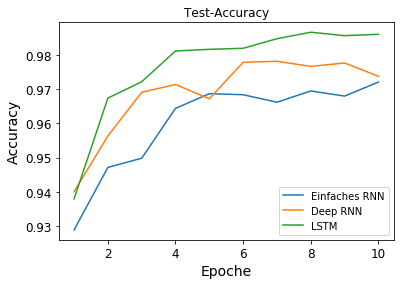

In [8]:
x = [i+1 for i in range(n_epochs)]
plt.plot(x, test_accuracy_simple_rnn, label="Einfaches RNN")
plt.plot(x, test_accuracy_deep_rnn, label="Deep RNN")
plt.plot(x, test_accuracy_lstm_rnn, label="LSTM")
plt.legend()
plt.xlabel("Epoche")
plt.ylabel("Accuracy")
plt.title("Test-Accuracy")
plt.show()